### Quick demo of slightly hacky catalog reader for cosmoDC2_v1.1.4_image 10 year mock error PDFs
The composite catalog of a composite catalog was not working properly with one catalog using "MATCHING_ORDER" to match the 10-year scattered magnitudes to the base cosmoDC2_v1.1.4_image catalog, and then also adding the PDF files for a *subset* of that data.  So, the solution I came up with was to create a composite catalog that matches the 10 year scattered photometry to the subset of objects with PDFs via a match by galaxy_id.  As the base scattered magnitudes are a line for line match to the cosmoDC2v1.1.4_image catalog, we can use the masked arrays from that catalog to also mask quantities in the base catalog, we just need to load both catalogs separately into readers and make sure that we make the *exact* cuts on each.  <br>

The new catalog is named `photoz_magerr_10y_with_pdfs`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

Load the local copy of gcr-catalogs branch that has the new catalog definitions, this branch is named `u/sschmidt23/mockpdfreader`<br>
which can be found at:<br>
https://github.com/LSSTDESC/gcr-catalogs/tree/u/sschmidt23/mockpdfreader

In [2]:
#sys.path.insert(0,"/global/homes/s/schmidt9/PZDC2/GCRreader/gcr-catalogs/lib/python3.7/site-packages/")
sys.path.insert(0,"/global/homes/s/schmidt9/PZDC2/GCRreader/gcr-catalogs/lib/python3.7/site-packages/GCRCatalogs-0.14.4-py3.7.egg")

In [3]:
import GCRCatalogs

In [4]:
import GCR
GCR.__version__
GCR.__path__

['/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/GCR']

In [5]:
GCRCatalogs.__path__

['/global/homes/s/schmidt9/PZDC2/GCRreader/gcr-catalogs/lib/python3.7/site-packages/GCRCatalogs-0.14.4-py3.7.egg/GCRCatalogs']

In [6]:
GCRCatalogs.__version__

'0.14.4'

In [7]:
#print('\n'.join(sorted(GCRCatalogs.get_available_catalogs(False))))

To start, load both catalogs 

In [8]:
cat = GCRCatalogs.load_catalog('photoz_magerr_10y_with_pdfs')
cat2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [19]:
sorted(cat.list_all_native_quantities())

[('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'galaxy_id'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'id/galaxy_id'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'pdf/pdf'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'photoz_mean'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'photoz_median'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'photoz_mode'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'photoz_mode_ml'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'photoz_mode_ml_red_chi2'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'photoz_odds'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'photoz_pdf'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'point_estimates/ODDS'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'point_estimates/z_mean'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat',
  'point_estimates/z_median'),
 ('cosmoDC2_v1.1.4_image_photoz_magerr_10y_PDFcat', 'point_estimates/z

In [10]:
#choose some columns to load from each catalog
cols = ['photoz_mode','photoz_median','galaxy_id','photoz_mode_ml','redshift','id/galaxy_id']
cols2 = ['ra','dec','redshift']

In [11]:
print(cat._native_filter_quantities)

{'redshift_block_lower', 'healpix_pixel'}


In [12]:
#I tested that the iterator returns things in the exact same order, so loading both with this form works
#gc_iterator = cat.get_quantities(cols,return_iterator=True)
#gc_it2 = cat2.get_quantities(cols2,return_iterator=True)


### masked arrays
Note that a composite catalog matched by galaxy_id or other quantity returns masked arrays of the length of the longer of the two catalogs.  In order to select only objects with mathces you will have to mask out the non-matching entries (somewhat non-intuitively by taking the inverse of the mask).  See examples below.

In [13]:
#for data in gc_iterator:
#    print(data.items())
#    zb =data['photoz_mode']
#    sz = data['redshift']
#   print(zb)
#    print(sz)
#    mask = ~zb.mask
#    print(np.sum(mask))
#    #cutsz = sz[mask]
#    #cutzb = zb[mask]

In [14]:
#using native filters also works, e.g. grabbign a few healpix pixels
natfilt = ['healpix_pixel==9815' or 'healpix_pixel==10067']
data1 = cat.get_quantities(cols, native_filters=natfilt)
data2 = cat2.get_quantities(cols2,native_filters=natfilt)

In [15]:
sz = data1['redshift']
id = data1['galaxy_id']
zb = data1['photoz_mode']
sz2 = data2['redshift']
ra2 = data2['ra']
print(len(zb))
print(len(sz))
print(len(sz2))
#we see that both redshift columns have the same number of entries, things have loaded properly
print(zb)
#and we see that the zb entries have been padded with masked values of '--'

17216765
17216765
17216765
[0.06499999761581421 0.07500000298023224 0.07500000298023224 ... -- -- --]


In [16]:
mask = ~zb.mask

In [17]:
szcut = sz[mask]
zbcut = zb[mask]
sz2cut = sz2[mask]

Text(0, 0.5, 'photoz_mode')

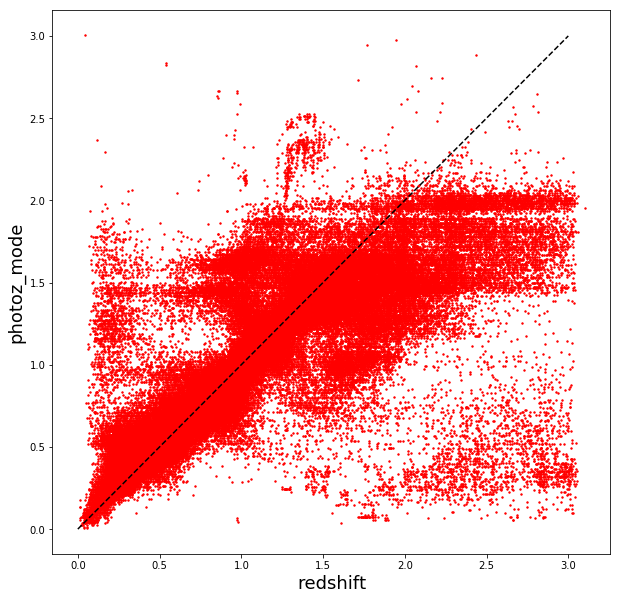

In [18]:
fig = plt.figure(figsize=(10,10))
plt.scatter(sz2cut[::10],zbcut[::10],s=2,c='r')
plt.plot([0,3],[0,3],'k--')
plt.xlabel('redshift',fontsize=18)
plt.ylabel('photoz_mode',fontsize=18)